In [1]:
import tensorflow as tf
from tensorflow.keras.layers import *
import numpy as np
import matplotlib.pyplot as plt
import itertools

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
       gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5000)])
    except RuntimeError as e:
        print(e)
        
AUTOTUNE = tf.data.experimental.AUTOTUNE             
PATH_TRAIN = "./facades/train/*"
PATH_TEST = "./facades/test/*"
BATCH_SIZE = 1
BUFFER_SIZE = 400
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256

In [2]:
def data_loader(PATH_TRAIN, PATH_TEST):
    train_list = tf.data.Dataset.list_files(PATH_TRAIN)
    test_list = tf.data.Dataset.list_files(PATH_TEST)
    train_dataset = train_list.map(image_processing, num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    test_dataset = test_list.map(image_processing, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE)
    return train_dataset, test_dataset

def image_processing(PATH):
    img = tf.io.read_file(PATH)
    real_image, label = decode_img(img)
    return real_image, label
    
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = (img-0.5)/0.5
    w = tf.shape(img)[1]//2
    real_image, label = img[:,:w,], img[:,w:,]
    if tf.random.uniform(()) > 0.5:
        real_image = tf.image.flip_left_right(real_image)   
        label = tf.image.flip_left_right(label)     
    if tf.random.uniform(()) > 0.5:
        real_image = tf.image.resize(real_image, [286, 286])
        label = tf.image.resize(label, [286, 286])
        stacked_image = tf.stack([real_image, label], axis=0)
        cropped_image = tf.image.random_crop(stacked_image, size=[2, IMAGE_HEIGHT, IMAGE_WIDTH, 3])
        real_image = cropped_image[0]
        label = cropped_image[1]
    return real_image, label

In [3]:
train_dataset, test_dataset = data_loader(PATH_TRAIN, PATH_TEST)

In [4]:
def encoder_layer(filters, input_layer):
    initializer = tf.random_normal_initializer(0., 0.02)
    x = Conv2D(filters=filters, kernel_size =4, padding= 'same', 
               strides=2, kernel_initializer=initializer, use_bias=False)(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def decoder_layer(filters, input_layer , concat_layer, dropout = False):
    initializer = tf.random_normal_initializer(0., 0.02)
    x = Conv2DTranspose(filters=filters, kernel_size=4, strides=2, padding="same", 
               kernel_initializer=initializer, use_bias=False)(input_layer)
    x = BatchNormalization()(x)
    if dropout:
        x = Dropout(0.5)(x)
    x = Concatenate()([x, concat_layer])
    x = Activation('relu')(x)
    return x


def generator_model():
    input_shape = (256,256,3)
    input_layer = Input(shape=input_shape)
    initializer = tf.random_normal_initializer(0., 0.02)

    encoder1 = Conv2D(filters=64, kernel_size =4, padding= 'same', strides=2, use_bias=False)(input_layer)
    encoder1 = LeakyReLU(alpha=0.2)(encoder1)
    
    encoder2 = encoder_layer(128, encoder1)
    
    encoder3 = encoder_layer(256, encoder2)

    encoder4 = encoder_layer(512, encoder3)
    
    encoder5 = encoder_layer(512, encoder4)
    
    encoder6 = encoder_layer(512, encoder5)
   
    encoder7 = encoder_layer(512, encoder6)

    encoder8 = encoder_layer(512, encoder7)
    
    decoder1 = decoder_layer(512 ,encoder8, encoder7, dropout=True)
    
    decoder2 = decoder_layer(512 ,decoder1, encoder6, dropout=True)
   
    decoder3 =  decoder_layer(512 ,decoder2, encoder5, dropout=True)

    decoder4 = decoder_layer(512 ,decoder3, encoder4)
    
    decoder5 = decoder_layer(256 ,decoder4, encoder3)

    decoder6 = decoder_layer(128 ,decoder5, encoder2)

    decoder7 = decoder_layer(64 ,decoder6, encoder1)
    
    decoder8 =Conv2DTranspose(filters=3, kernel_size=4, strides=2, padding="same", 
               kernel_initializer=initializer, use_bias=False, activation="tanh")(decoder7)
    
    return tf.keras.Model(inputs=[input_layer], outputs= [decoder8])
        
def discriminator_model():
    input_image = Input(shape = (256,256,3))
    input_target = Input(shape=(256,256,3))
    initializer = tf.random_normal_initializer(0., 0.02)
    
    input_layer = Concatenate()([input_image, input_target])
        
    x = Conv2D(filters=64, kernel_size=4, strides=2, padding="same", 
               kernel_initializer=initializer, use_bias=False)(input_layer)
    x = LeakyReLU(alpha=0.2)(x)
     
    x = Conv2D(filters=128, kernel_size=4, strides=2, padding="same", 
               kernel_initializer=initializer, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
        
    x = Conv2D(filters=256, kernel_size=4, strides=2, padding="same", 
               kernel_initializer=initializer, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = ZeroPadding2D()(x)
    
    x = Conv2D(filters=512, kernel_size=4, strides=1, 
               kernel_initializer=initializer, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = ZeroPadding2D()(x)

    x = Conv2D(filters=1, kernel_size=4, strides=1,
               kernel_initializer=initializer)(x)
    
    return tf.keras.Model(inputs = [input_image, input_target], outputs = [x])
    

In [5]:
generator= generator_model()
discriminator = discriminator_model()

In [6]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training = False)
    plt.figure(figsize = (15,15))
    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

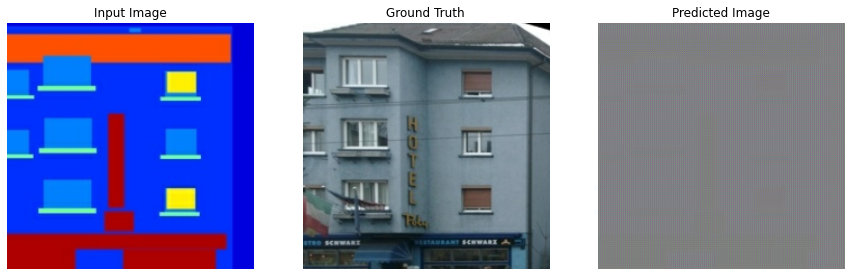

In [7]:
for i, (tar, input_image) in enumerate(test_dataset.take(1)):
    generate_images(generator, input_image, tar)

In [8]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def g_loss(disc_fake_output, gen_output, target):
    gan_loss = cross_entropy(tf.ones_like(disc_fake_output), disc_fake_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_loss = gan_loss + 100 * l1_loss
    return total_loss, gan_loss, l1_loss

def d_loss(fake_image, real_image):
    disc_real_loss = cross_entropy(tf.ones_like(real_image), real_image)
    disc_fake_loss = cross_entropy(tf.zeros_like(fake_image), fake_image)
    return disc_real_loss + disc_fake_loss

In [9]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5, beta_2= 0.999)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 =0.5, beta_2= 0.999)

In [10]:
import datetime
import time
from IPython import display

log_dir = "logs/"

summary_writer = tf.summary.create_file_writer(log_dir+"fit/"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [11]:
@tf.function
def train_step(input_image, target, epochs):
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training = True)
        
        disc_real_output = discriminator([input_image, target], training = True)
        disc_fake_output = discriminator([input_image, gen_output], training = True)
    
        disc_loss = d_loss(disc_fake_output, disc_real_output)
        gen_total_loss, gen_loss, l1_loss = g_loss(disc_fake_output, gen_output, target)
        
    generator_of_gradient = gen_tape.gradient(gen_total_loss,  generator.trainable_variables)
    discriminator_of_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_of_gradient, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_of_gradient, discriminator.trainable_variables))
    
    return gen_total_loss, gen_loss, l1_loss, disc_loss

In [12]:
def train(train_ds, test_ds, epochs):
    for epoch in range(epochs):
        start_time = time.time()
        gen_total_loss, gen_loss, l1_loss, disc_loss = 0, 0, 0, 0
        for n, (target, input_image) in enumerate(train_ds):
            print('.', end='')
            if (n+1) % 100 == 0:
                print()
            loss = train_step(input_image, target, epoch)
            gen_total_loss += loss[0].numpy()
            gen_loss += loss[1].numpy()
            l1_loss += loss[2].numpy()
            disc_loss += loss[3].numpy()
        display.clear_output(wait=True)
        
        for tar, input_image in test_dataset.take(1):
            generate_images(generator, input_image, tar)
            
        print("epoch : {}, time {}".format(epoch+1, time.time() - start_time)) 
        
        with summary_writer.as_default():
            tf.summary.scalar('gen_total_loss', gen_total_loss/BUFFER_SIZE, step = epoch+1)
            tf.summary.scalar('gen_gan_loss', gen_loss/BUFFER_SIZE, step =epoch+1)
            tf.summary.scalar('l1_loss', l1_loss/BUFFER_SIZE, step =epoch+1)
            tf.summary.scalar('disc_loss', disc_loss/BUFFER_SIZE, step =epoch+1)

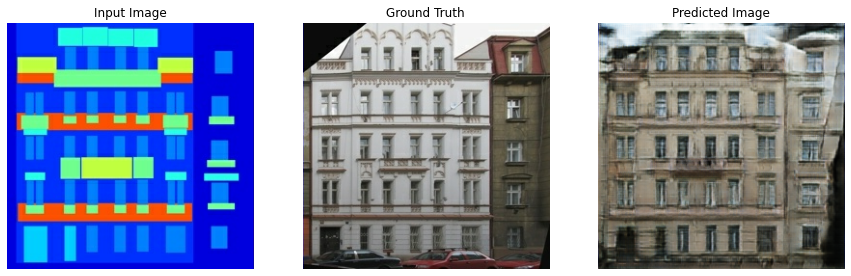

epoch : 100, time 27.106101989746094
CPU times: user 48min 38s, sys: 25 s, total: 49min 3s
Wall time: 45min 25s


In [13]:
%%time
train(train_dataset, test_dataset,100)

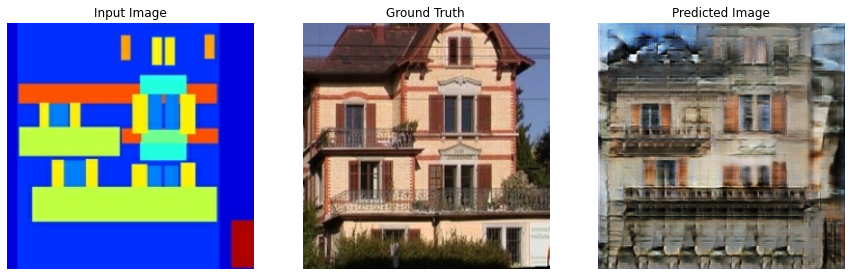

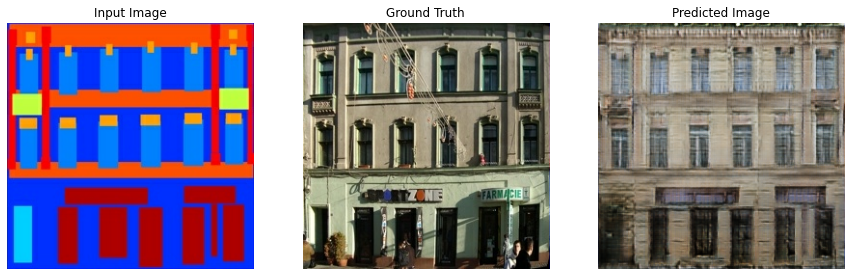

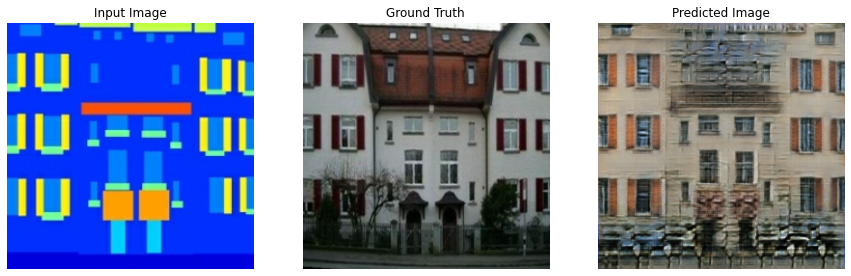

In [14]:
for i, (tar, input_image) in enumerate(test_dataset.take(3)):
    generate_images(generator, input_image, tar)